In [30]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance

#from tqdm.notebook import tqdm

## Monday Week 1 (08/07/2024): Have to create a class for a bound mass profile
 - Look at https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/profiles/nfw.py as an example of the creation of a halo mass profile.
 - Python docs on classes: https://docs.python.org/3/tutorial/classes.html
 - Selected bits: 
   - the class inheritance mechanism allows multiple base classes
   - a derived class can override any methods of its base class or classes
   - a method can call the method of a base class with the same name

$\rho_X(r)\ = Ma ^{-3} f_X g_X(r)\$. 

- M = total halo mass
- $f_X$ = the fraction of that mass in gas species X
- $g(x)$ = the profile, which satisfies the normalisation $4\pi \int^{\infty}_0 dr\ r^2 g_X(r)\ = 1$
- a = the scale factor

$f_c + f_b + f_e + f_* = 1$ AND (assuming adiabaticity) $f_b + f_e + f_* = \bar{f}_b \equiv \frac{\Omega_b}{\Omega_M}$

----------------------------------------------------------------------------
In [paper](../Background-reading/XrayCrossCorrelations-1.pdf), see that:   
$\rho_x(r)\ = M f_x\ a^{-3} g_x(r)\ $    

$f_b(M) = []$   
$g_b(r)\ = \frac{1}{V_b} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ , where $log \equiv ln$.    
$V_b \equiv 4\pi r_s^3 I_b(\frac{1}{\Gamma - 1}, 0)\ $   
$I_b(\gamma, q)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\gamma} j_0(qx)\ $, with $ q = kr_s $ [in Fourier space].   
$\to I_b(\frac{1}{\Gamma - 1}, 0)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}} j_0(0)\  = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}$   
As $j_0 $ is a Besel function, & $j_0(0)\ = 1 $.

Therefore:   
$\rho_x(r)\ = \frac{M f_x\ }{4\pi r_s^3 a^{3}} \frac{1}{\int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ 

$\tilde{g}_b(k)\ = \frac{I_b(1/(\Gamma - 1),q)\ }{I_b(1/(\Gamma - 1),0)\ } $ , with $q = kr_s$
- already have $I_b(1/(\Gamma - 1),0)\ $, so:
- need to write function for $I_b(1/(\Gamma - 1),q)\ $ (another interpolator)
- and, in _fourier function, call $\tilde{g}_b(k)\ $ for the particular (gamma, r_s) pars over k

In [181]:
def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
    return x * (np.log(1+x)/x)**gam # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]

        # ? could use np.meshgrid instead of the nested for loops ?
k=0
for i in gamma_list:
    l=0
    for j in q_array:
                # j0(x*q[=r_s*k]) = sinc(q*x) (so weight by sinc, with wvar = q) [for weight = 'cos' -> cos(w*x)]
        I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                        # _innerInt(self, x, gam=1/(gamma_use-1))
        l+=1
    k+=1
       #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4399/3851261446.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return x * (np.log(1+x)/x)**gam # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4399/3851261446.py:10: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4399/3851261446.py:10: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector 

In [191]:
func_normQany(gamma_list[0], np.log(q_array)[0])

ValueError: Method '-6.907755278982137' is not defined

In [32]:
np.shape(np.linspace(1.01, 10, 1000)) == np.shape(np.zeros(1000))

GammaRange = (1.01, 10)
nGamma= 1000
qrange=(1e-3, 1e3)
nq= 10_000
# recheck order of indexing is correct with shape of I0 array
gamma_list = np.linspace(GammaRange[0], GammaRange[1], nGamma) # start, stop, number of evenly spaced samples
q_array = np.geomspace(qrange[0], qrange[1], nq) # q = k*r_s, k will be from geomspace
I0_array =  np.zeros((nGamma, nq))
print(I0_array)
print(np.shape(I0_array))

k=0
for i in gamma_list:
    l=0
    print(f'k = {k/len(gamma_list)}% through')
    for j in q_array:
       # print(f'l = {l/len(q_array):.3g}% through')
                # j0(x*q[=r_s*k]) = sinc(q*x) (so weight by sinc, with wvar = q) [for weight = 'cos' -> cos(w*x)]
        I0_array[k, l] =  k+l # integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1), weight = np.sinc, wvar=j)[0] 
                        # _innerInt(self, x, gam=1/(gamma_use-1))
        l+=1
    k+=1
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
#func_normQ0 = # interpol.interp1d(gamma_list, I0_array) # interp1d(x, y,
print(I0_array)
np.shape(I0_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 10000)
k = 0.0% through
k = 0.001% through
k = 0.002% through
k = 0.003% through
k = 0.004% through
k = 0.005% through
k = 0.006% through
k = 0.007% through
k = 0.008% through
k = 0.009% through
k = 0.01% through
k = 0.011% through
k = 0.012% through
k = 0.013% through
k = 0.014% through
k = 0.015% through
k = 0.016% through
k = 0.017% through
k = 0.018% through
k = 0.019% through
k = 0.02% through
k = 0.021% through
k = 0.022% through
k = 0.023% through
k = 0.024% through
k = 0.025% through
k = 0.026% through
k = 0.027% through
k = 0.028% through
k = 0.029% through
k = 0.03% through
k = 0.031% through
k = 0.032% through
k = 0.033% through
k = 0.034% through
k = 0.035% through
k = 0.036% through
k = 0.037% through
k = 0.038% through
k = 0.039% through
k = 0.04% through
k = 0.041% through
k = 0.042% through
k = 0.043% through


(1000, 10000)

In [46]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, r_s=1, GammaRange = (1.01, 10), nGamma=1000, qrange=(1e-3, 1e3), nq=10_000): 
        # will change later, but can leave characteristic scale as ~ 1 Mpc for the moment
        self.r_s = r_s  # may need to add an rEj parameter into real & Fourier profiles below
        super(boundGas_profile, self).__init__(mass_def=mass_def)

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        # General normalised profile (for q=0, over Gamma)
        self._func_normQ0 = None 
        # Interpolator for dimensionless Fourier-space profile
        self._func_normQany = self._norm_interpol2()
        #self._func_normQany = None


    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
        return x**2 * self._shape(x, gam)   # eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, gamma, rS=1):
        rS_use = np.atleast_1d(rS)
        gamma_use = np.atleast_1d(gamma)

      #  def innerInt(x, gam=1/(gamma_use-1)): #(a, gam=1/(gamma_use-1), b=1, c=1):
       #     return x**2 * self._shape(x, gam)     # eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam
        
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(gamma_use-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(rS_use**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)

        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y,
        return func_normQ0
        
    def _real(self, r, M, gamma, r_s=1, call_interp=True,
              scale_a=1, f=1): # set the default pars for scale factor a & fraction of total mass f
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)
        gamma_use = np.atleast_1d(gamma)

        if call_interp==False:
            vB_prefix = self._Vb_prefix(gamma_use, rS_use)[0]
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(rS_use**3)*self._func_normQ0(gamma_use)  # self._Vb_prefix(gamma_use, rS_use)[0]
    #    else:
      #      vB_prefix = self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * f * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / rS_use[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(gamma_use-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

#### THEN DO FOURIER EQN!!!

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * self._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]

        # ? could use np.meshgrid instead of the nested for loops ?
        k=0
        for i in gamma_list: # tqdm(gamma_list):
            l=0
            for j in q_array: #tqdm(q_array):
                # j0(x*q[=r_s*k]) = sinc(q*x) (so weight by sinc, with wvar = q) [for weight = 'cos' -> cos(w*x)]
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                        # _innerInt(self, x, gam=1/(gamma_use-1))
                l+=1
               # print(f'l = {100*l/self.nq:.3g}% through')
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')

        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, gamma, r_s = 1,
                 a=1, f=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = self._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = self._norm_interpol2()

        # g(k) = Ib_qAny / Ib_q0 = self._func_normQany / self.func_normQ0 
        q_use = k_use[None, :]*rS_use
        g_k = self._func_normQany(gamma_use, np.log(q_use)) / self._func_normQ0(gamma_use)
        # and need to add in pars (gamma, q=r_s*k) to get the particular g(k) for this profile (*then* multiply by prefix)
        
        ####

        prefix = M_use * f / a**3
      #  x = k_use[None, :] * rEj_use[:, None]
        # delete: prof = np.exp(-(1/2)*(r_use[None, :]/r_ej[:, None])**2)
        prof = prefix[:, None] * g_k[None,:] # np.exp(-(x**2)/2)

        #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [ ]:
trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1 # np.array([2,3,4])
# working with z = 0 (today) ; therefore a = 1 [default]
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
bd_rsTrial = 1
trial_interpd_boundProf = boundGas_profile(hmd_200c)

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/2676227979.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(1+x)/x)**gam_use
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/2676227979.py:102: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 0.1% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/2676227979.py:102: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 0.2% through
k = 0.3% through
k = 0.4% through
k = 0.5% through
k = 0.6% through
k = 0.7% through
k = 0.8% through
k = 0.9% through
k = 1% through
k = 1.1% through
k = 1.2% through
k = 1.3% through
k = 1.4% through
k = 1.5% through
k = 1.6% through
k = 1.7% through
k = 1.8% through
k = 1.9% through
k = 2% through
k = 2.1% through
k = 2.2% through
k = 2.3% through
k = 2.4% through
k = 2.5% through
k = 2.6% through
k = 2.7% through
k = 2.8% through
k = 2.9% through
k = 3% through
k = 3.1% through
k = 3.2% through
k = 3.3% through
k = 3.4% through
k = 3.5% through
k = 3.6% through
k = 3.7% through
k = 3.8% through
k = 3.9% through
k = 4% through
k = 4.1% through
k = 4.2% through
k = 4.3% through
k = 4.4% through
k = 4.5% through
k = 4.6% through
k = 4.7% through
k = 4.8% through
k = 4.9% through
k = 5% through
k = 5.1% through
k = 5.2% through
k = 5.3% through
k = 5.4% through
k = 5.5% through
k = 5.6% through
k = 5.7% through
k = 5.8% through
k = 5.9% through
k = 6% through
k = 6.1% 

In [38]:
profTrial_interpd_real = trial_interpd_boundProf._real(trial_r, trial_M, trial_gamma, bd_rsTrial, call_interp=True) 
# _real(self, r, M, gamma, r_s=1, call_interp=True, scale_a=1, f=1):
profTrial_interpd_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/3940917193.py:49: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/3940917193.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be 

array([[7.20581585e+12, 7.20573357e+12, 7.20565126e+12, ...,
        3.42181202e-55, 3.41436878e-55, 3.40694171e-55],
       [2.88232634e+13, 2.88229343e+13, 2.88226051e+13, ...,
        1.36872481e-54, 1.36574751e-54, 1.36277669e-54],
       [1.44116317e+14, 1.44114671e+14, 1.44113025e+14, ...,
        6.84362404e-54, 6.82873755e-54, 6.81388343e-54]])

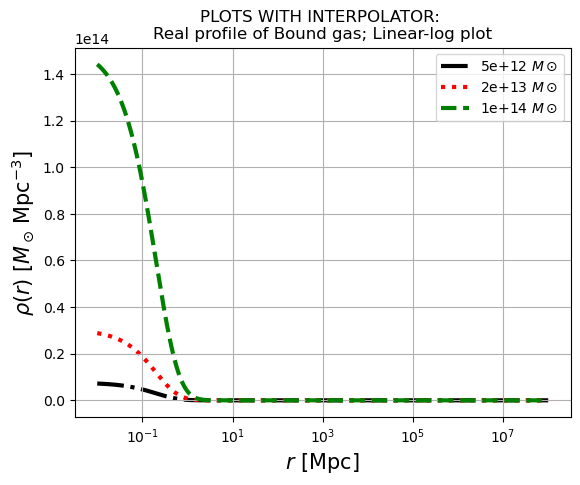

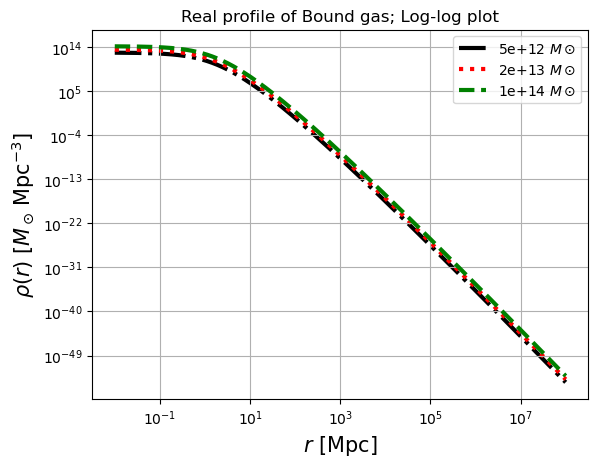

In [9]:
colours, i = ['k-.', 'r:', 'g--'], 0
for j in trial_M:
    plt.plot(trial_r, profTrial_interpd_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('PLOTS WITH INTERPOLATOR: \nReal profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_interpd_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

# PLOTS WITH INTERPOLATOR ABOVE!
# PLOTS *WITHOUT* INTERPOLATOR BELOW!

(DO NOT RE-RUN CELLS BELOW UNLESS HAVE REVERTED TO OLD CODE!!!)

Characteristic scale $r_s$ should be ~ 1 Mpc (so leave as = 1), and gamma $\Gamma$ (which has no real physical significance, just a fitting number) should be around ~ 1.1-1.2 (but when doing normalisation interpolator, should do for $\Gamma \in [1.01,10]$ ).

In [16]:
profTrial_real = trial_interpd_boundProf._real(trial_r, trial_M, trial_gamma, bd_rsTrial, call_interp=False) # WITHOUT interpolator
# _real(self, r, M, gamma, r_s=1, call_interp=True, scale_a=1, f=1):
profTrial_real

array([[7.20643922e+12, 7.20635693e+12, 7.20627462e+12, ...,
        3.42210804e-55, 3.41466415e-55, 3.40723645e-55],
       [2.88257569e+13, 2.88254277e+13, 2.88250985e+13, ...,
        1.36884322e-54, 1.36586566e-54, 1.36289458e-54],
       [1.44128784e+14, 1.44127139e+14, 1.44125492e+14, ...,
        6.84421608e-54, 6.82932830e-54, 6.81447289e-54]])

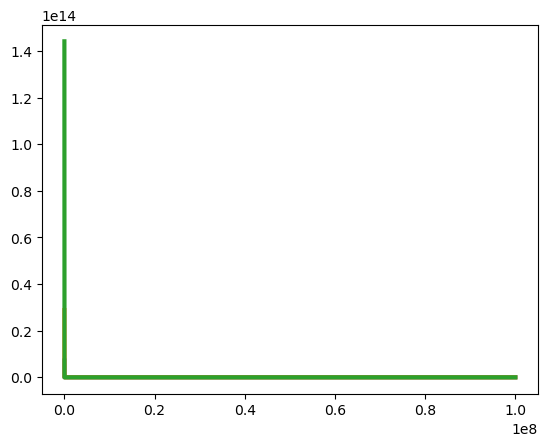

In [123]:
i=0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], lw=3, zorder = i)
    i+=1

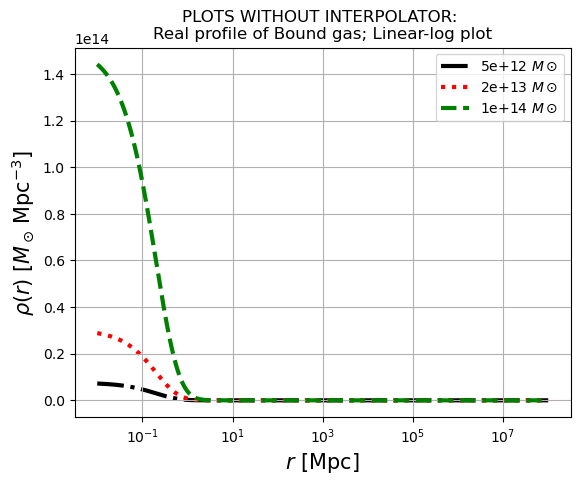

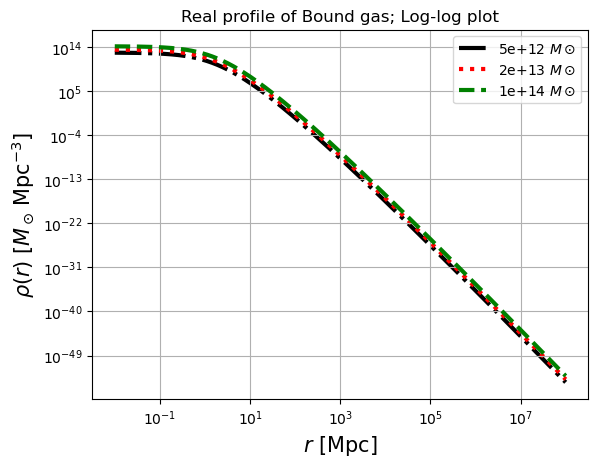

In [29]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('PLOTS WITHOUT INTERPOLATOR: \nReal profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
#plt.xlim(1e-2,1e5);  #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
#plt.xlim(1e-2,1e5);  #plt.ylim(1e-2,1e5);

## Comparing Real profile with & without interpolator

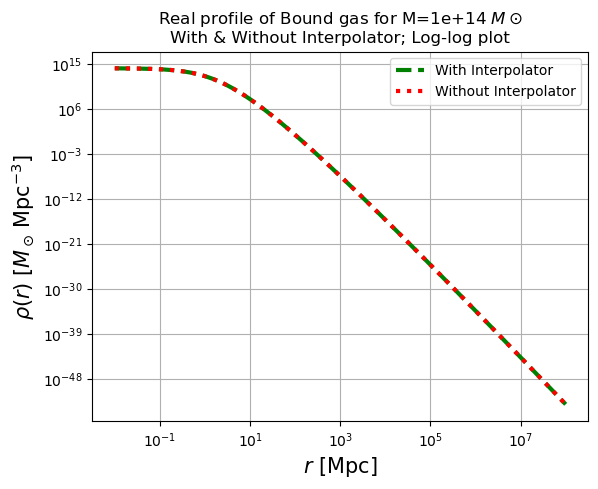

In [26]:
plt.plot(trial_r, profTrial_interpd_real[2], 'g--', lw=3, label='With Interpolator')
plt.plot(trial_r, profTrial_real[2], 'r:', lw=3, label='Without Interpolator')
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(f'Real profile of Bound gas for M={trial_M[2]:.1g} $M\\odot $\nWith & Without Interpolator; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

# Fourier profile for the bound gas 

In [ ]:
trial_k = np.geomspace(1E-20,1E2,100000)
trial_M = np.array([5E12,2E13, 1E14])
profTrial_fourier = trial_interpd_boundProf._fourier(trial_k, trial_M, trial_gamma)
profTrial_fourier  #_fourier(self, k, M, gamma, r_s=1, a=1, f=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

l = 0.01% through
l = 0.02% through
l = 0.03% through
l = 0.04% through
l = 0.05% through
l = 0.06% through
l = 0.07% through
l = 0.08% through
l = 0.09% through
l = 0.1% through
l = 0.11% through
l = 0.12% through
l = 0.13% through
l = 0.14% through
l = 0.15% through
l = 0.16% through
l = 0.17% through
l = 0.18% through
l = 0.19% through
l = 0.2% through
l = 0.21% through
l = 0.22% through
l = 0.23% through
l = 0.24% through
l = 0.25% through
l = 0.26% through
l = 0.27% through
l = 0.28% through
l = 0.29% through
l = 0.3% through
l = 0.31% through
l = 0.32% through
l = 0.33% through
l = 0.34% through
l = 0.35% through
l = 0.36% through
l = 0.37% through
l = 0.38% through
l = 0.39% through
l = 0.4% through
l = 0.41% through
l = 0.42% through
l = 0.43% through
l = 0.44% through
l = 0.45% through
l = 0.46% through
l = 0.47% through
l = 0.48% through
l = 0.49% through
l = 0.5% through
l = 0.51% through
l = 0.52% through
l = 0.53% through
l = 0.54% through
l = 0.55% through
l = 0.56% throu

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/3845190484.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(1+x)/x)**gam_use
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/3845190484.py:100: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


l = 50% through
l = 50% through
l = 50% through
l = 50% through
l = 50% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.1% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.2% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.3% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.4% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.5% through
l = 50.6% through
l 

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4414/3845190484.py:100: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 66.9% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.1% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.2% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.3% through
l = 67.4% through
l = 67.4% through
l = 67.4% through
l = 67.4% through
l = 67.4% through
l = 67.4% through
l = 67.4% through
l = 67.4% thro

In [124]:
#### colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3)
    i+=1
# plt.ylabel(r'$\rho(k)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
# plt.xlabel(r'$k\,\,[{\rm Mpc}]$', fontsize=15);
plt.xscale('log');

i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Log-log plot')
plt.grid(True)
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);

NameError: name 'profTrial_fourier' is not defined